# Классификатор эмоций

В этом нойтбуке создается и обучается модель для классификации эмоций по изображению лица

In [1]:
import tensorflow as tf 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input, decode_predictions as resnet50_decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input, decode_predictions as vgg16_decode_predictions 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input, decode_predictions as xception_decode_predictions 


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from pathlib import Path

import random
import datetime as dt 
import os

## Опредление путей к данным

In [2]:
# флаг использования Google drive как хранилища данных
USE_GOOGLE_DRIVE = False

#Корневая папка проекта
root_dir = ''

In [3]:
#Подключаем google drive, если код будет выполняться в Colab
if USE_GOOGLE_DRIVE:
    from google.colab import drive

    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Projects/EmoDetector'
    
    import sys
    sys.path.append(root_dir)

    #скачиваем исходные данные
    import gdown
    url = 'https://drive.google.com/uc?id=1pm86O0t_0caQq3b3Qz5iNI3T77p2o-C1'
    output = 'train.zip'
    gdown.download(url, output, quiet=False)

    #распакуем архив
    !unzip -q train.zip

#if

In [4]:
import emo_utils as utils

In [5]:
#Получаем пути к директориям и файлам проекта

paths = utils.get_paths(root_dir)

print (paths)

{'data_dir': 'data', 'model_dir': 'model', 'train_data_dir': 'data/train', 'train_aug_data_dir': 'data/train_aug', 'val_data_dir': 'data/val', 'test_data_dir': 'data/test_kaggle', 'class_names_path': 'data/class_names.txt', 'best_checkpoint_path': 'model/emo_classificator_best'}


In [ ]:
'Переопределяем локальные пути к данным для Google Colab'
if USE_GOOGLE_DRIVE:
    paths['train_data_dir'] = '/content/train'
    paths['train_aug_data_dir'] = '/content/train_aug'
    paths['val_data_dir'] = '/content/val'
#if

## Создание модели

In [21]:
# Гиперпараметры
BATCH_SIZE = 32
IMAGE_SIZE = 224
VALIDATION_SPLIT = 0.2
NUM_CLASSES = 9
EPOCHS = 20
LEARNING_RATE=0.01

#тип базовой модели
BASE_MODEL = 'resnet50'

#Флаг использования аугментации
USE_AUGMENTATION = False

#Тип используемой аугментации
#0 - не используется
#1 - используется аугментация "на лету", случайным образом измененные картинки генерируются генератором в процессе обучения
#2 - используется заранее сгенерированный расширенный (аугментированный) набор изображений для обучения
AUG_TYPE = 2

#Флаг что модель будет дообучаться
RESUME_TRAINING = False
#Чекпоинт, с которого продолжиться обучение
checkpoint_path = paths['model_dir'] + '/emo_classificator_best_resnet50_e10_acc_34.h5'

In [23]:
def create_model (p_base_model, p_num_classes = 9):
    '''
    Создание модели для классификации эмоций по картинке
    
    :argument
    p_base_model - тип базовой модели:
     resnet50
     vgg16
     xception
         
    p_num_classes - количество определяемых классов
    
    return:
    base_model- базовая модель, предназначенная для извлечения признаков с картинки
    model - модель для классификации эмоций, построенная на базовой модели
    preprocessed_input - функция для обработки входных данных для базовой модели
    decode_predictions - функция для расшифровки предсказания базовой модели
    
    '''
    
    base_model = None
    model = None
    preprocess_input = None
    decode_predictions = None
    
    if p_base_model == 'resnet50':        
        
        base_model = ResNet50(weights='imagenet')
        #отрежем последние слои
        #base_layers = tf.keras.Model([base_model.input], base_model.get_layer("avg_pool").output)
        base_layers = ResNet50(weights="imagenet",
                               input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                               include_top=False)
        
        #добавим новые слои для обучения и классификации
#        model = tf.keras.Sequential([base_layers,
#                                 tf.keras.layers.Flatten(),
#                                 tf.keras.layers.Dense(1024, activation='relu'),
#                                 tf.keras.layers.Dense(p_num_classes, activation='softmax')])

        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Dense(1024, activation='relu'),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        preprocess_input = resnet50_preprocess_input
        decode_predictions = resnet50_decode_predictions
        
    #if
    if p_base_model == 'vgg16':            
             
        base_model = VGG16(weights='imagenet')
        #отрежем последние слои
        base_layers = tf.keras.Model([base_model.input], base_model.get_layer('block5_pool').output)
        
        #добавим новые слои для обучения и классификации
        model = tf.keras.Sequential([base_layers,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(512, activation='relu'),
                                 tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        preprocess_input = vgg16_preprocess_input
        decode_predictions = vgg16_decode_predictions
        
    #if
    
    if p_base_model == 'xception':
        
             
        base_model = Xception(weights='imagenet')
        #отрежем последние слои
#        base_layers = tf.keras.Model([base_model.input], base_model.get_layer('avg_pool').output)
                
        base_layers = tf.keras.applications.Xception(weights="imagenet",
                                                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                 include_top=False)
    
        #добавим новые слои для обучения и классификации
#        model = tf.keras.Sequential([base_layers,
#                                 tf.keras.layers.Flatten(),
#                                 tf.keras.layers.Dense(1024, activation='relu'),
#                                 tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
#        model = tf.keras.Sequential([base_layers,
#                                     tf.keras.layers.GlobalAveragePooling2D(),
#                                     tf.keras.layers.Dropout(0.2),
#                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])

        model = tf.keras.Sequential([base_layers,
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dropout(0.5),
                                     tf.keras.layers.Dense(512, activation='relu'),
                                     tf.keras.layers.Dropout(0.5),
                                     tf.keras.layers.Dense(128, activation='relu'),
                                     tf.keras.layers.Dropout(0.5),
                                     tf.keras.layers.Dense(p_num_classes, activation='softmax')])
        
        
        
        preprocess_input = xception_preprocess_input
        decode_predictions = xception_decode_predictions
        
    #if
    
    
    #"заморозим" базовые слои
    base_layers.trainable = False
      
    return base_model, model, preprocess_input, decode_predictions

#create_model

In [24]:
base_model, model_emo_classifier, preprocess_input, decode_predictions = create_model (p_base_model=BASE_MODEL)

model_emo_classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 9225      
Total params: 25,695,113
Trainable params: 2,107,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

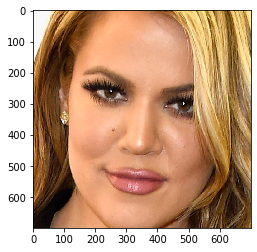

Predicted: [('n03676483', 'lipstick', 0.40090147), ('n03916031', 'perfume', 0.054402642), ('n03476991', 'hair_spray', 0.051147483)]


In [26]:
#Проверим базовую модель

img_path = paths['test_data_dir'] + '/4999.jpg'

#Отобразим картинку
plt.imshow(mpimg.imread(img_path))
plt.show()

x = utils.preprocess_image(img_path, (IMAGE_SIZE, IMAGE_SIZE), preprocess_input)

preds = base_model.predict(x)

#print(preds)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [28]:
# Создадим генератор картинок для обучения модели

if AUG_TYPE < 2:

    if AUG_TYPE == 0:
        image_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                       validation_split = VALIDATION_SPLIT)
    
    elif AUG_TYPE == 1:
        image_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                       validation_split = VALIDATION_SPLIT,
                                       horizontal_flip=True,
                                       zoom_range=0.2,
                                       height_shift_range=0.2,
                                       width_shift_range=0.2,
                                       rotation_range=15)
    
    train_generator = image_gen.flow_from_directory (directory= paths['train_data_dir'],
                                                     class_mode= 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                     subset = 'training')

    val_generator = image_gen.flow_from_directory (directory= paths['train_data_dir'],
                                                   class_mode= 'categorical', 
                                                   batch_size = BATCH_SIZE, 
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   subset = 'validation',
                                                   shuffle = False)

#if

elif AUG_TYPE == 2:
    image_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
    
    train_generator = image_gen.flow_from_directory (directory= paths['train_aug_data_dir'],
                                                     class_mode= 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE))

    val_generator = image_gen.flow_from_directory (directory= paths['val_data_dir'],
                                                   class_mode= 'categorical', 
                                                   batch_size = BATCH_SIZE, 
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                    shuffle = False)
#elif
    

Found 79639 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


In [29]:
# Сохраним список классов, чтобы можно было их в последствии декодировать

classes_names = ''
for key in train_generator.class_indices.keys():
    if classes_names == '': 
        classes_names = key
    else:
        classes_names = classes_names + ',' + key

with open(paths['class_names_path'], 'w') as output:
    output.write(classes_names)

In [30]:
aug = ''
if AUG_TYPE > 0:
    aug = '_aug'+str(AUG_TYPE)

if not RESUME_TRAINING:
    checkpoint_path = paths['best_checkpoint_path'] \
                      +'_'+ dt.datetime.now().strftime ('%y%m%d%H%M%S') \
                      +'_'+ BASE_MODEL \
                      + '_e'+ str(EPOCHS) \
                      + aug +'.h5'

    #скомпилируем модель
    model_emo_classifier.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                 loss= 'categorical_crossentropy',
                                 metrics= ['accuracy'])

#    model_emo_classifier.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#                                 loss= 'categorical_crossentropy',
#                                 metrics= ['accuracy'])
#if
else:
    # Загрузим модель
    model_emo_classifier = tf.keras.models.load_model(checkpoint_path)
      
    checkpoint_path =  checkpoint_path.replace('.h5', '_e' + str(EPOCHS) + '.h5')
#else    


#Создаем объект для сохранения модели во время обучения
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor= 'val_accuracy',
                                                verbose= 1, 
                                                save_best_only= True, 
                                                mode='max')

In [31]:
# Обучение модели

history = model_emo_classifier.fit(train_generator,
                                   validation_data = val_generator,
                                   epochs = EPOCHS,
                                   callbacks = [checkpoint])

Epoch 1/20
2489/2489 [==============================] - ETA: 0s - loss: 1.9991 - accuracy: 0.2603
Epoch 00001: val_accuracy improved from -inf to 0.29659, saving model to model/emo_classificator_best_201230083842_resnet50_e20_aug2.h5
2489/2489 [==============================] - 4452s 2s/step - loss: 1.9991 - accuracy: 0.2603 - val_loss: 1.9150 - val_accuracy: 0.2966
Epoch 2/20
2489/2489 [==============================] - ETA: 0s - loss: 1.9222 - accuracy: 0.2947
Epoch 00002: val_accuracy improved from 0.29659 to 0.31688, saving model to model/emo_classificator_best_201230083842_resnet50_e20_aug2.h5
2489/2489 [==============================] - 4645s 2s/step - loss: 1.9222 - accuracy: 0.2947 - val_loss: 1.8700 - val_accuracy: 0.3169
Epoch 3/20
2489/2489 [==============================] - ETA: 0s - loss: 1.8919 - accuracy: 0.3085
Epoch 00003: val_accuracy improved from 0.31688 to 0.32397, saving model to model/emo_classificator_best_201230083842_resnet50_e20_aug2.h5
2489/2489 [===========

In [32]:
history.history

{'loss': [1.9990615844726562,
  1.9222252368927002,
  1.8919087648391724,
  1.865403175354004,
  1.843414545059204,
  1.8238675594329834,
  1.8040705919265747,
  1.7869248390197754,
  1.7693839073181152,
  1.7520742416381836,
  1.7267358303070068,
  1.7091829776763916,
  1.6846917867660522,
  1.6674489974975586,
  1.6495431661605835,
  1.6225403547286987,
  1.6137187480926514,
  1.5875517129898071,
  1.5739420652389526,
  1.5519261360168457],
 'accuracy': [0.26032471656799316,
  0.294717401266098,
  0.30845439434051514,
  0.31858763098716736,
  0.32779166102409363,
  0.3366692066192627,
  0.3451952040195465,
  0.35397228598594666,
  0.35800299048423767,
  0.36254850029945374,
  0.3751051723957062,
  0.380077600479126,
  0.38985922932624817,
  0.39883723855018616,
  0.40532904863357544,
  0.41576364636421204,
  0.41882744431495667,
  0.42987731099128723,
  0.4352892339229584,
  0.44266000390052795],
 'val_loss': [1.9149622917175293,
  1.8700475692749023,
  1.8745007514953613,
  1.866797

In [33]:
#Добавляем информацию о точности в название чекпоинта

acc = str(int(round(max(history.history['val_accuracy']), 2)*100))

new_checkpoint_path = checkpoint_path.replace ('.h5', '_acc' + acc + '.h5')

os.rename (checkpoint_path, new_checkpoint_path)
checkpoint_path = new_checkpoint_path

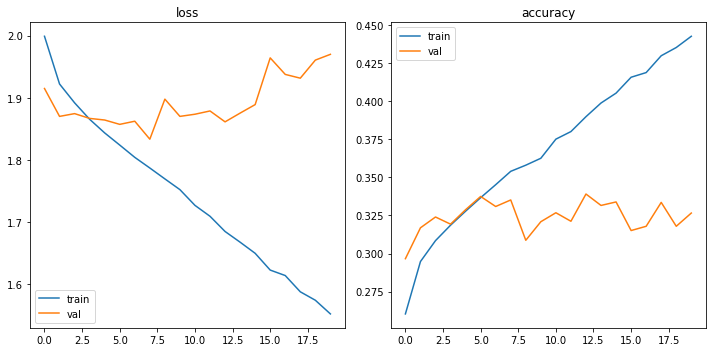

In [34]:
#Визуализируем данные обучения

fig = plt.figure(tight_layout=True)

#задаем размерность сетки для размещения графиков
gs= fig.add_gridspec(1,2)
fig.set_size_inches(10, 5)

ax = fig.add_subplot(gs[0,0])
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'val')
        
#Добавление подписей на график
ax.set_title('loss')
ax.legend()

ax = fig.add_subplot(gs[0,1])
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'val')

ax.set_title('accuracy')
ax.legend()

plt.savefig(checkpoint_path.replace('.h5', '.png'))
plt.show()

## Тест модели

In [35]:
# Загрузим модель
model = tf.keras.models.load_model(checkpoint_path)

#model.evaluate(val_generator)

In [36]:
#загрузим названия классов
classes_names = []
with open(paths['class_names_path'], 'r') as f:
    classes_names = f.read().split(',')

In [37]:
# выберем картинки для проверки
sample_cnt = 12

sample_img_paths = []
sample_img_labels = []
for i in range (sample_cnt):
    index = random.choice(range(0, len(val_generator.filepaths)))
    sample_img_paths.append (val_generator.filepaths[index])
    sample_img_labels.append (val_generator.labels[index])
    
#for

print (sample_img_paths)
print (sample_img_labels)

['data/val/surprise/3122.jpg', 'data/val/anger/2167.jpg', 'data/val/fear/3962.jpg', 'data/val/contempt/1041.jpg', 'data/val/uncertain/4891.jpg', 'data/val/happy/5717.jpg', 'data/val/neutral/4485.jpg', 'data/val/uncertain/2929.jpg', 'data/val/happy/1213.jpg', 'data/val/anger/4031.jpg', 'data/val/fear/1444.jpg', 'data/val/contempt/2978.jpg']
[7, 0, 3, 1, 8, 4, 5, 8, 4, 0, 3, 1]


In [61]:
#import importlib
#importlib.reload (utils)

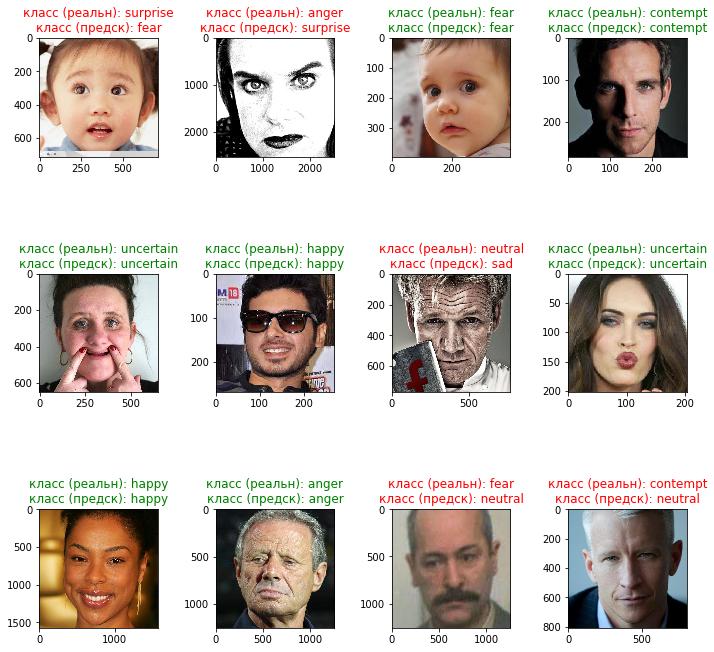

In [38]:
# Тест предсказания

utils.test_model_prediction (p_model = model,
                             p_img_paths = sample_img_paths,
                             p_img_emo_idxs = sample_img_labels,
                             p_img_target_size = (IMAGE_SIZE, IMAGE_SIZE),
                             preprocess_func = preprocess_input,
                             p_emo_classes_names = classes_names)